In [604]:
# Necessary packages
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
import utils

In [605]:
orig_data_dir = "../../data/processed_orig_data/"
gen_data_dir = "../../data/generated_data/"

# Load data

In [606]:
dataset = 'stocks'           # sine, stocks, air, energy
perc = 100
model = 'vae_conv_I'

# orig data

sample_file_name = orig_data_dir + f'{dataset}_subsampled_train_perc_{perc}.npz'
loaded = np.load(sample_file_name)
orig_data = loaded['data']
print(orig_data.shape)


# gen data
sample_file_name = gen_data_dir + f'{model}_gen_samples_{dataset}_perc_{perc}.npz'
loaded = np.load(sample_file_name)
gen_data = loaded['data']
print(gen_data.shape)



(3661, 24, 6)
(3661, 24, 6)


In [607]:
N, T, D = orig_data.shape

# Scale Data

In [608]:
class MinMaxScaler():
    """Min Max normalizer.
    Args:
    - data: original data

    Returns:
    - norm_data: normalized data
    """
    def fit_transform(self, data): 
        self.fit(data)
        scaled_data = self.transform(data)
        return scaled_data


    def fit(self, data):    
        self.mini = np.min(data, 0)
        self.range = np.max(data, 0) - self.mini
        return self
        

    def transform(self, data):
        numerator = data - self.mini
        scaled_data = numerator / (self.range + 1e-7)
        return scaled_data

    
    def inverse_transform(self, data):
        data *= self.range
        data += self.mini
        return data

In [609]:
print(orig_data.mean(axis=0).mean(axis=1))
print(gen_data.mean(axis=0).mean(axis=1))

[1238941.44316377 1236946.40925923 1235954.5135954  1235195.68369254
 1234588.24385721 1234232.43112133 1233960.66033937 1233788.08344109
 1233608.83198479 1233452.75521079 1233135.28354159 1232496.92307027
 1232338.90707974 1232139.10853254 1231997.24813597 1231874.9557154
 1231522.30985982 1231220.59798117 1230781.19066007 1230327.7674456
 1229949.35326411 1229558.39757784 1229112.4563705  1228820.3244087 ]
[1262274.22774111 1261255.86225447 1260078.19811107 1259143.64554188
 1259386.85241472 1259889.91652894 1259737.95006528 1257791.99562166
 1255570.28819926 1258972.83537394 1258661.47629981 1257676.98545238
 1256450.4901454  1257285.08067388 1255842.82572036 1254507.00480736
 1253600.42252557 1256084.00979278 1254591.76005689 1254088.92756169
 1252881.79838863 1255281.76848067 1251945.33087917 1252806.07028341]


In [610]:
scaler_orig = MinMaxScaler( )  
scaled_orig_data = scaler_orig.fit_transform(orig_data)
print('scaled orig data shape: ', scaled_orig_data.shape)
print('scaled orig data mean: ', scaled_orig_data.mean())

scaler_gen = MinMaxScaler( )  
scaled_gen_data = scaler_orig.transform(gen_data)
print('scaled gen data shape: ', scaled_gen_data.shape)
print('scaled gen data mean: ', scaled_gen_data.mean())

scaled orig data shape:  (3661, 24, 6)
scaled orig data mean:  0.2892493093648157
scaled gen data shape:  (3661, 24, 6)
scaled gen data mean:  0.2805676936621104


In [611]:
print(scaled_orig_data.mean(axis=0).mean(axis=1))
print(scaled_gen_data.mean(axis=0).mean(axis=1))

[0.28818122 0.28822461 0.28841546 0.2886137  0.28881881 0.28902849
 0.28923789 0.28944822 0.28965798 0.28987007 0.29008394 0.29020806
 0.2902559  0.29032908 0.29047756 0.29022314 0.28967846 0.28930371
 0.28906335 0.28887134 0.28849906 0.28831381 0.28850287 0.28867671]
[0.27952232 0.27964553 0.27978539 0.27997089 0.2801982  0.28039207
 0.28059734 0.28076976 0.28100285 0.28124734 0.28144393 0.2815986
 0.28162005 0.2816557  0.28179745 0.28150648 0.28088969 0.28061629
 0.28030739 0.28014421 0.2797492  0.27957609 0.27968458 0.27990331]


In [612]:
print('scaled orig data min/max: ', scaled_orig_data.min(), scaled_orig_data.max())
print('scaled orig scaled_gen_data min/max: ', scaled_gen_data.min(), scaled_gen_data.max())

scaled orig data min/max:  0.0 0.9999999999999988
scaled orig scaled_gen_data min/max:  -0.03568854927723809 1.736392900170172


In [613]:
final_orig = scaled_orig_data.mean(axis=2)
final_gen = scaled_gen_data.mean(axis=2)
print('final_orig shape: ', final_orig.shape)
print('final_gen shape: ', final_gen.shape)

final_orig shape:  (3661, 24)
final_gen shape:  (3661, 24)


In [614]:
final_tsne_input = np.concatenate((final_orig, final_gen), axis = 0)
# final_tsne_input = final_orig

print('final_tsne_input shape: ', final_tsne_input.shape)

final_tsne_input shape:  (7322, 24)


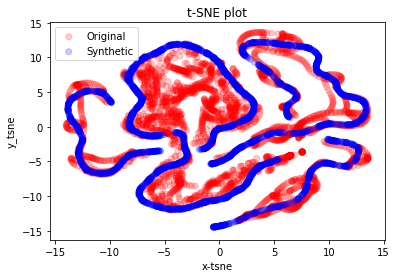

In [617]:
# TSNE analysis
tsne = TSNE(n_components = 2, perplexity = 40, n_iter = 300)
tsne_results = tsne.fit_transform(final_tsne_input)


colors = ["red" for i in range(N)] + ["blue" for i in range(N)] 

# Plotting
f, ax = plt.subplots(1)

plt.scatter(tsne_results[:N,0], tsne_results[:N,1], 
            c = colors[:N], alpha = 0.2, label = "Original")
plt.scatter(tsne_results[N:,0], tsne_results[N:,1], 
            c = colors[N:], alpha = 0.2, label = "Synthetic")

ax.legend()

plt.title('t-SNE plot')
plt.xlabel('x-tsne')
plt.ylabel('y_tsne')
plt.savefig("tsne-results.png", dpi=300)  
plt.show()

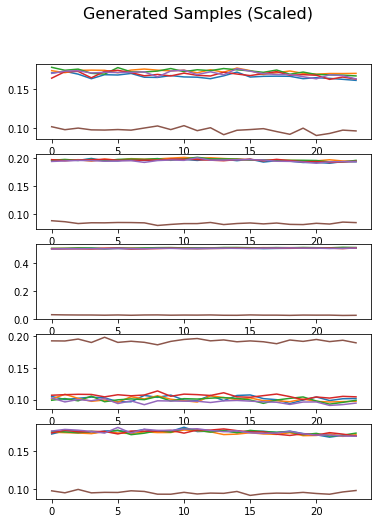

In [616]:
utils.plot_samples(scaled_gen_data, n=5)